In [67]:
import rawpy
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imageio
from PIL import Image

# 白平衡处理

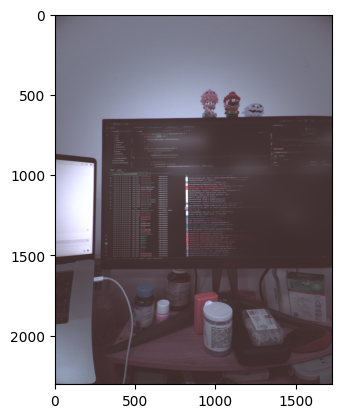

In [68]:
with rawpy.imread('dng/sensor_raw_1739933611742.dng') as raw:
    bayer = raw.raw_image_visible.astype(np.float32)
    wb = raw.camera_whitebalance
    
    #灰度世界假设
    r_gain = bayer[0::2, 1::2].mean() / bayer[0::2, 0::2].mean()  # G/R
    b_gain = bayer[0::2, 1::2].mean() / bayer[1::2, 0::2].mean()  # G/B

    
    #白平衡增益
    bayer[0::2, 0::2] *= r_gain  # R通道
    bayer[1::2, 0::2] *= b_gain  # B通道

    R = bayer[0::2, 0::2]
    B = bayer[1::2, 0::2]
    G = (bayer[0::2, 1::2] + bayer[1::2, 1::2]) / 2

    rgb = np.dstack((R, G, B))
    rgb_show = (rgb / np.percentile(rgb, 99) * 255).clip(0,255).astype(np.uint8)
    rgb_show = np.rot90(rgb_show, 3)
    plt.imshow(rgb_show)
    plt.savefig('1.pdf')

# 颜色校正矩阵

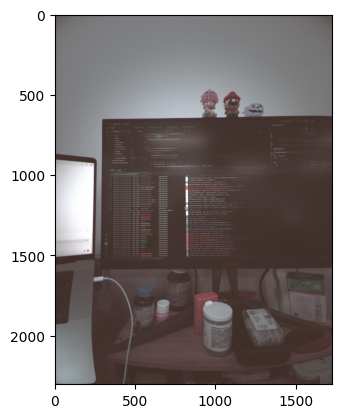

In [69]:
ccm = np.array([[0.9, 0.1, 0],  
                [0, 1.0, 0],
                [0, 0.05, 0.85]])
rgb = np.dot(rgb, ccm.T)
rgb_show = (rgb / np.percentile(rgb, 99) * 255).clip(0,255).astype(np.uint8)
rgb_show = np.rot90(rgb_show,3)
plt.imshow(rgb_show)
plt.savefig('2.pdf')

# sRGB conersion

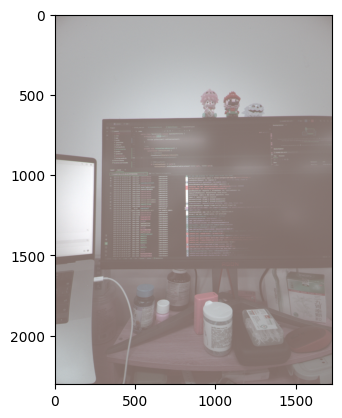

In [80]:
def linear_to_srgb(rgb_linear):
    """ 实现标准sRGB光电转换函数(OETF) """
    cutoff = 0.0031308
    a = 0.055
    rgb_linear = np.clip(rgb_linear, 0, 1)  # 确保输入在[0,1]范围
    
    # 分段处理
    srgb = np.where(
        rgb_linear <= cutoff,
        12.92 * rgb_linear,
        1.055 * np.power(rgb_linear, 1/2.4) - a
    )
    return srgb

max_val = np.percentile(rgb,99.9)  # 或使用 np.percentile(rgb, 99.9) 保留高光细节
rgb_normalized = rgb / max_val

rgb_srgb = linear_to_srgb(rgb_normalized)

# 将sRGB转换为8位RGB
rgb_8bit = (rgb_srgb * 255).clip(0, 255).astype(np.uint8)
rgb_srgb = np.rot90(rgb_srgb, 3)
plt.imshow(rgb_srgb)

# 伽马矫正

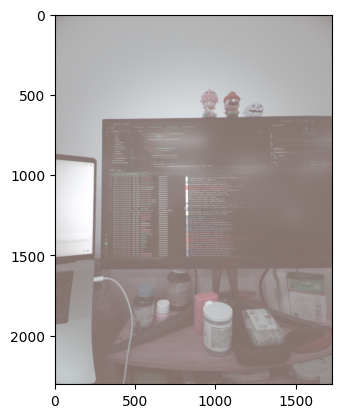

In [70]:
gamma = 2.2

#线性化后再进行伽马校正
max_val = np.percentile(rgb, 99.5)
rgb_norm = (rgb / max_val).clip(0, 1)

rgb_gamma = np.power(rgb_norm, 1/gamma)

rgb_8bit = (rgb_gamma * 255).astype(np.uint8)
rgb_8bit = np.rot90(rgb_8bit,k=3)

plt.imshow(rgb_8bit)
plt.savefig('3.pdf')